In [1]:
%pylab inline
import numpy as np
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors

Populating the interactive namespace from numpy and matplotlib


In [2]:
#raw_data=sc.textFile("/home/ubuntu/workspace/project/data/1601/1601_05_merge_1d.csv")
#raw_data=sc.textFile("/home/ubuntu/workspace/project/data/1601/1601_06_del_date.csv") #date가 제거된 데이터
raw_data=sc.textFile("/home/csxion/Desktop/project/data/1601/1601_07_standard.csv")
records=raw_data.map(lambda line:line.split(","))
records.first()

['가락시장역',
 '5',
 '0.488862391',
 '0.492025331',
 '0.377386277',
 '0.900759881',
 '0.946628724',
 '0.92233892',
 '0.932746679',
 '78']

In [3]:
subway_dict=records.map(lambda r:r[0]).distinct().zipWithIndex().collectAsMap() # distinct 꼭 사용할 것
#date_dict=records.map(lambda r:r[1]).distinct().zipWithIndex().collectAsMap()

In [4]:
def extract_features(r): #line별
    #name_date=[int(subway_dict[r[0]]), int(date_dict[r[1]])]
    name=[int(subway_dict[r[0]])]
    number=[float(r[i]) for i in range(1,len(r)-1)]
    #return name_date+number #python에서는 연접하는법이 간단함
    return name+number
#flatMap을 사용할 필요가 없음

def extract_label(r):
    return int(r[len(r)-1]) # int는 소문자로 지정해야 함

In [5]:
data=records.map(lambda r:LabeledPoint(extract_label(r), Vectors.dense(np.array(extract_features(r)))))
data.cache

<bound method RDD.cache of PythonRDD[9] at RDD at PythonRDD.scala:48>

In [6]:
data.first()

LabeledPoint(78.0, [39.0,5.0,0.488862391,0.492025331,0.377386277,0.900759881,0.946628724,0.92233892,0.932746679])

In [45]:
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.tree import DecisionTree
# Linear모델의 train / DT모델의 trainRegressor를 이용한다

linear_model=LinearRegressionWithSGD.train(data, iterations=1000, step=0.0001)

/usr/local/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


In [46]:
true_vs_predicted=data.map(lambda p:(p.label, linear_model.predict(p.features)))
true_vs_predicted.take(100)

[(78.0, 1163.8194548639219),
 (183.0, 1202.3000194762606),
 (143.0, 1241.2014392353901),
 (261.0, 1280.152903129203),
 (286.0, 1318.607926752321),
 (316.0, 1357.5158185401469),
 (393.0, 1396.6410771935043),
 (424.0, 1435.5834558897243),
 (452.0, 1474.3242889873998),
 (467.0, 1512.9938645561122),
 (459.0, 1551.8241684545167),
 (506.0, 1590.8502025810012),
 (490.0, 1629.5897171396189),
 (436.0, 1668.3611639823393),
 (305.0, 1707.0536632269755),
 (317.0, 1745.918500321472),
 (299.0, 1784.6210716007281),
 (291.0, 1823.3004189836008),
 (186.0, 1862.0575371245984),
 (1555.0, 1509.3642335290194),
 (1890.0, 1548.1383281867156),
 (1436.0, 1587.021823533056),
 (1878.0, 1626.1333002830183),
 (2683.0, 1664.7717518901584),
 (2673.0, 1703.4946545202897),
 (2884.0, 1742.4921081774794),
 (3884.0, 1781.2774876328226),
 (4411.0, 1820.4027462620272),
 (4785.0, 1859.260592114347),
 (4903.0, 1898.0132133898719),
 (6092.0, 1936.6355695320067),
 (6634.0, 1975.3702696192988),
 (6518.0, 2014.4006706995156),
 (

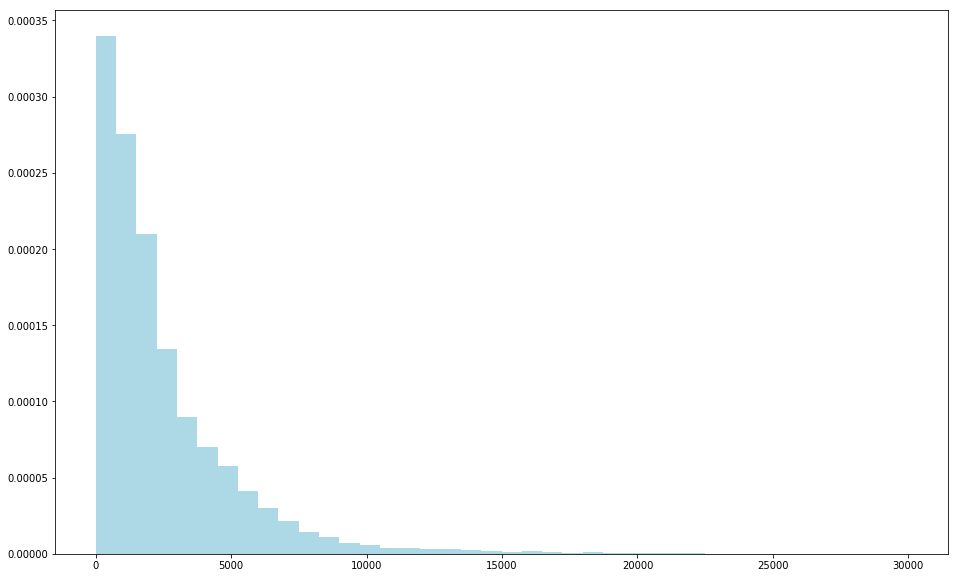

In [9]:
#타켓 변수 변환
targets=records.map(lambda r:float(r[-1])).collect()
hist(targets, bins=40, color='lightblue', normed='True')
fig=matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

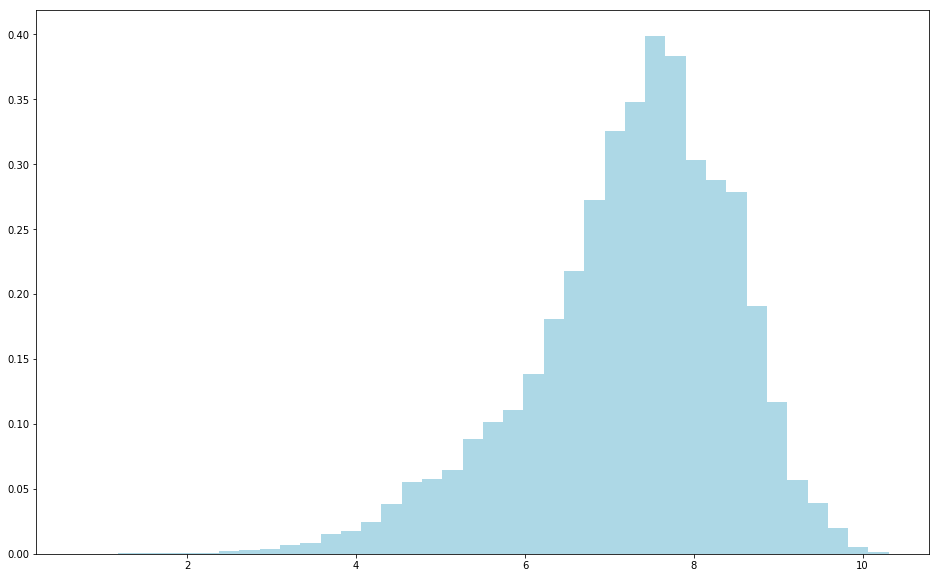

In [10]:
log_targets=records.map(lambda r:np.log(float(r[-1]))).collect()
hist(log_targets, bins=40, color="lightblue", normed=True)
fig=matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)
#실제로 로그화를 하면 보다 정규분포에 가까운것을 볼 수 있다

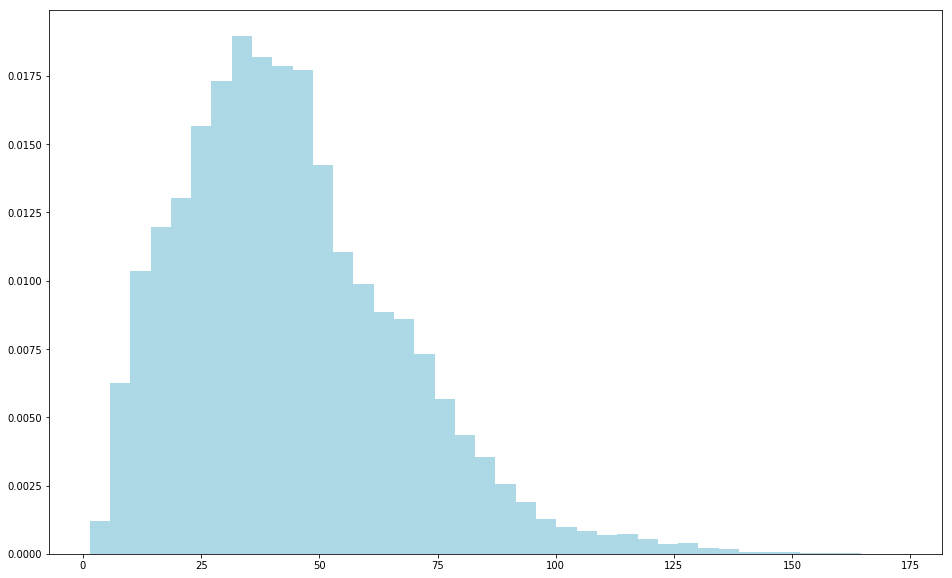

In [11]:
sqrt_targets=records.map(lambda r:np.sqrt(float(r[-1]))).collect()
hist(sqrt_targets, bins=40, color='lightblue', normed=True)
fig=matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)
#음수 값이 없는 타켓에만 적용 가능, 타켓 변수의 제곱근 구하기

In [72]:
data_log=data.map(lambda lp:LabeledPoint(np.log(lp.label), lp.features))
model_log=LinearRegressionWithSGD.train(data_log, iterations=100000, step=0.001) #iterations에 특정 변화가 없음
true_vs_predicted_log=data_log.map(lambda p:(np.exp(p.label),np.exp(model_log.predict(p.features))))

/usr/local/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


In [73]:
true_vs_predicted_log.take(100)
#크게 달라지는게 없는 듯 한데.. 모르겠다
#true_vs_predicted.take(5)

[(78.0, 26.706783634966065),
 (183.00000000000009, 33.881311053649064),
 (142.99999999999994, 43.123234671887694),
 (261.00000000000006, 54.907629576311557),
 (285.99999999999994, 69.643943297476483),
 (316.00000000000006, 88.644067036986058),
 (393.0, 113.01642119471785),
 (424.0, 143.88736194611258),
 (452.00000000000017, 182.90756423370664),
 (467.00000000000006, 232.38034721558358),
 (459.00000000000006, 295.60545407854693),
 (506.00000000000011, 376.60116598635562),
 (489.99999999999983, 478.72872523312219),
 (435.99999999999994, 608.7032150701782),
 (305.00000000000006, 773.49276746178555),
 (316.99999999999989, 984.20431874666349),
 (299.00000000000011, 1250.7457089399379),
 (291.00000000000011, 1589.195995935703),
 (186.00000000000009, 2020.4324974251319),
 (1554.9999999999998, 55.265371040495623),
 (1890.0000000000007, 70.270281970644362),
 (1435.9999999999998, 89.426052320169063),
 (1878.0000000000002, 114.0043142315613),
 (2682.9999999999995, 144.80602666813803),
 (2672.9999

In [14]:
#특징 표준화를 위한 RowMatrix
from pyspark.mllib.linalg.distributed import RowMatrix
vectors=data.map(lambda lp:lp.features)
matrix=RowMatrix(vectors)
matrixSummary=matrix.computeColumnSummaryStatistics()

In [15]:
#matrixSummary.mean()
matrixSummary.variance()
matrixSummary.max()

array([ 109.        ,   23.        ,    0.98863378,    1.        ,
          0.99999999,    0.90934105,    0.94662872,    0.92233892,
          0.93274668])

In [16]:
from pyspark.mllib.feature import StandardScaler
scaler=StandardScaler(withMean=True, withStd=True).fit(vectors)
scaledData=data.map(lambda lp:LabeledPoint(lp.label, lp.features))
scaledData.take(2)
scaler.transform(data.first().features) #이렇게 하면 잘 실행됨, 리턴값은 DenseVector 형태
label=records.map(lambda lb:extract_label(lb))
scaled_raw_data=label.zip(scaler.transform(vectors))
scaled_data=scaled_raw_data.map(lambda lp:LabeledPoint(lp[0], Vectors.dense(lp[1].toArray())))
#scaledData=data.map(lambda lp:LabeledPoint(lp.label, scaler.transform(lp.features))) #이렇게 하면 에러가 나고

In [17]:
scaled_data.take(3) #에러 안나게 완료

[LabeledPoint(78.0, [-0.495624573692,-1.6431559508,-0.0881649982576,-0.0199908634625,-0.36547567757,1.23446981337,1.42306020697,1.31801713273,1.35718695614]),
 LabeledPoint(183.0, [-0.495624573692,-1.46058306738,-0.0881649982576,-0.0199908634625,-1.18979319106,1.23446981337,1.42306020697,1.31801713273,1.35718695614]),
 LabeledPoint(143.0, [-0.495624573692,-1.27801018396,-0.0621147750758,-0.0199908634625,-0.887844754369,1.23446981337,1.42306020697,1.31801713273,1.35718695614])]

In [18]:
linear_model_scaled=LinearRegressionWithSGD.train(scaled_data, iterations=100000, step=0.0000001)
true_vs_predicted_scaled=scaled_data.map(lambda p:(p.label, linear_model_scaled.predict(p.features)))
true_vs_predicted_scaled.take(5)
#왜 예측할때마다 터무니 없는 음수가 나올까.. 정확한 값도 아니고

/usr/local/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[(78.0, -6.7153532804959859e-05),
 (183.0, -6.3587185577526016e-05),
 (143.0, -5.5871241773933333e-05),
 (261.0, -4.7454974358158213e-05),
 (286.0, -4.4343500378750877e-05)]

In [19]:
#dt model 학습 시작
dt_model=DecisionTree.trainRegressor(data, {})
preds=dt_model.predict(data.map(lambda d:d.features))
actual=data.map(lambda d:d.label)
true_vs_predicted_dt=actual.zip(preds)
true_vs_predicted_dt.take(5)

[(78.0, 372.0562640660165),
 (183.0, 1106.4384463462804),
 (143.0, 3227.1486586570113),
 (261.0, 3227.1486586570113),
 (286.0, 3227.1486586570113)]

In [20]:
data_with_idx=data.zipWithIndex().map(lambda p:(p[1],p[0]))
test=data_with_idx.sample(False, 0.2, 42)
train=data_with_idx.subtractByKey(test)

In [21]:
train_data=train.map(lambda p:p[1])
test_data=test.map(lambda p:p[1])
train_size=train_data.count()
test_size=test_data.count()
print("Training data Size : %d"%train_size)
print("Test data Size : %d"%test_size)

Training data Size : 56108
Test data Size : 13983


In [22]:
data_with_idx_dt=data.zipWithIndex().map(lambda p:(p[1], p[0]))
test_dt=data_with_idx_dt.sample(False, 0.2, 42)
train_dt=data_with_idx_dt.subtractByKey(test_dt)
train_data_dt=train_dt.map(lambda p:p[1])
test_data_dt=test_dt.map(lambda p:p[1])

In [23]:
def squared_error(actual, pred):
    return (pred-actual)**2
def abs_error(actual,pred):
    return np.abs(actual-pred)
def squared_log_error(actual, pred):
    return (np.log(pred+1)-np.log(actual+1))**2

In [24]:
#LinearRegression 모델 테스트 메소드
def evaluate(train, test, iterations, step, regParam, regType, intercept):
    model=LinearRegressionWithSGD.train(train, iterations, step, regParam=regParam, regType=regType, intercept=intercept)
    tp=test.map(lambda p:(p.label, model.predict(p.features)))
    rmsle=np.sqrt(tp.map(lambda p:squared_log_error(p[0], p[1])).mean())
    return rmsle

In [25]:
#DecisionTree 모델 테스트 메소드
def evaluate_dt(train, test, maxDepth, maxBins):
    model=DecisionTree.trainRegressor(train, {}, impurity='variance', maxDepth=maxDepth, maxBins=maxBins)
    preds=model.predict(test.map(lambda p:p.features))
    actual=test.map(lambda p:p.label)
    tp=actual.zip(preds)
    rmsle=np.sqrt(tp.map(lambda p:squared_log_error(p[0], p[1])).mean())
    return rmsle

[1, 2, 3, 4, 5, 10, 20]
[1.2153026559192104, 1.1757724536936456, 1.147490785277316, 1.1262448879295222, 1.1080338447756957, 0.98716158428092571, 1.038985887140347]


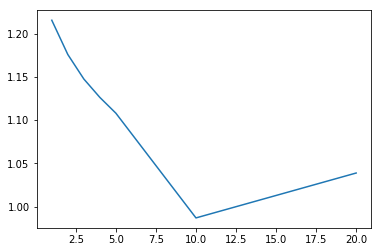

In [26]:
#depth=32로 한뒤, bins의 최적화 여부를 판단한다.
params=[1,2,3,4,5,10,20]
metrics=[evaluate_dt(train_data_dt, test_data_dt, param, 32) for param in params]
print(params)
print(metrics)
plot(params,metrics)
fig=matplotlib.pyplot.gcf()

[16, 32, 64, 128, 256]
[1.0474462721021376, 0.98716158428092571, 0.78962583592412328, 0.61436301270389637, 0.6150633824539472]


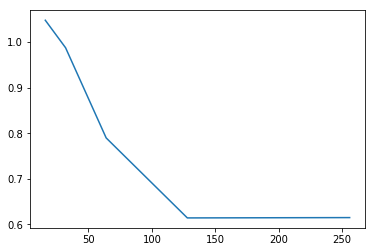

In [27]:
#depth=10로 했을때, depth의 변화량에 따라..
# 많은 저장소를 사용하면, 모델을 더 정교하게 트레이닝 할 수 잇어야 하며, 실제 테스트 데이터 집합에 따라 과도하게 변형될 수 있음
params=[16,32,64,128,256]
metrics=[evaluate_dt(train_data_dt, test_data_dt, 10, param) for param in params]
print(params)
print(metrics)
plot(params, metrics)
fig=matplotlib.pyplot.gcf()

In [28]:
#bins=128, depth=10

evaluate_dt(train_data_dt, test_data_dt, maxBins=128, maxDepth=10)

0.61436301270389637

In [29]:
final_model_dt=model=DecisionTree.trainRegressor(train_data_dt, {}, impurity='variance', maxDepth=10, maxBins=128)

In [30]:
#최적값 확보 후 모델 성립. 이후 테스트
final_preds_vs_actual=test_data_dt.map(lambda p:(p.label, final_model_dt.predict(p.features)))
final_preds_dt=final_model_dt.predict(test_data_dt.map(lambda d:d.features))
final_actual_dt=test_data_dt.map(lambda d:d.label)
final_true_vs_predicted_dt=actual.zip(preds)
final_true_vs_predicted_dt.take(30)

[(78.0, 372.0562640660165),
 (183.0, 1106.4384463462804),
 (143.0, 3227.1486586570113),
 (261.0, 3227.1486586570113),
 (286.0, 3227.1486586570113),
 (316.0, 3227.1486586570113),
 (393.0, 3227.1486586570113),
 (424.0, 3227.1486586570113),
 (452.0, 3227.1486586570113),
 (467.0, 3227.1486586570113),
 (459.0, 3227.1486586570113),
 (506.0, 3227.1486586570113),
 (490.0, 3227.1486586570113),
 (436.0, 3227.1486586570113),
 (305.0, 3227.1486586570113),
 (317.0, 3227.1486586570113),
 (299.0, 3227.1486586570113),
 (291.0, 3227.1486586570113),
 (186.0, 1395.9565503620804),
 (1555.0, 372.0562640660165),
 (1890.0, 1793.8978494623657),
 (1436.0, 3244.2418300653594),
 (1878.0, 3244.2418300653594),
 (2683.0, 3244.2418300653594),
 (2673.0, 3244.2418300653594),
 (2884.0, 3244.2418300653594),
 (3884.0, 3244.2418300653594),
 (4411.0, 3244.2418300653594),
 (4785.0, 3244.2418300653594),
 (4903.0, 3244.2418300653594)]

/usr/local/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[1, 5, 10, 20, 50, 100]
[3.4779136558012929, 2.5214042765493039, 2.2081639483585502, 1.9527503318053911, 1.7031171215371788, 1.5783341561137134]


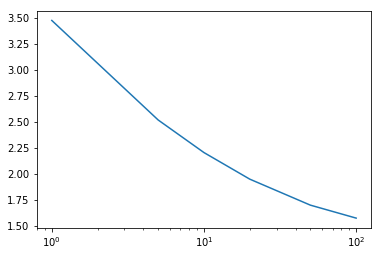

In [31]:
#LinearRegressionModel
##iterations 변수 설정
params=[1,5,10,20,50,100]
metrics=[evaluate(train_data, test_data, param, 0.00001, 0.0, 'l2', False) for param in params]
print(params)
print(metrics)
plot(params, metrics)
fig=matplotlib.pyplot.gcf()
pyplot.xscale('log') # x좌표의 기준단위를 log로 전환

/usr/local/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[0.0001, 0.0005, 0.001, 0.005, 0.01]
[1.33145566965832, 1.2664572838367734, 1.261293070632586, nan, nan]


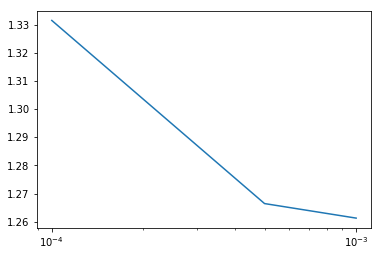

In [32]:
#LinearRegressionModel
##stepSize설정
params=[0.0001, 0.0005, 0.001, 0.005, 0.01]
metrics=[evaluate(train_data, test_data, 1000, param, 0.0, 'l2', False) for param in params]
print(params)
print(metrics)
plot(params, metrics)
fig=matplotlib.pyplot.gcf()
pyplot.xscale('log')
#예상외로 치고 올라가는 그래프가 나오지 않음
# 대신에 nan값으로, 수치를 벗어남

/usr/local/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
[1.261293070632586, 1.2612937826867294, 1.2613170265808054, 1.2614022504855733, 1.2619079057387392, 1.2626686851238738, 1.2646316135661388]


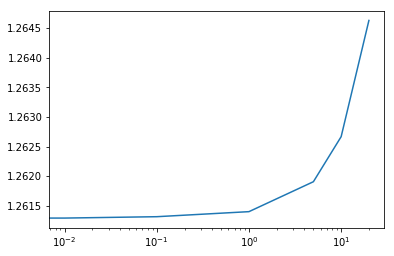

In [33]:
#LinearRegressionModel
##L2 규칙화 정도
# 규칙화를 증가시키면 training set의 성능이 약화되나, 테스트 데이터 집합에서 최적의 성능을 낼 수 있음

params=[0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
#50.0, 100.0, 200.0, 500.0, 600.0, 1000.0] #기존보다 상당히 높임
metrics=[evaluate(train_data, test_data, 1000, 0.001, param, 'l2', False) for param in params]
print(params)
print(metrics)
plot(params, metrics)
fig=matplotlib.pyplot.gcf()
pyplot.xscale('log')

/usr/local/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[10000.0, 1000000.0, 10000000.0, 100000000.0]
[nan, 7.3658485427408857, 7.3658485427408857, 7.3658485427408857]


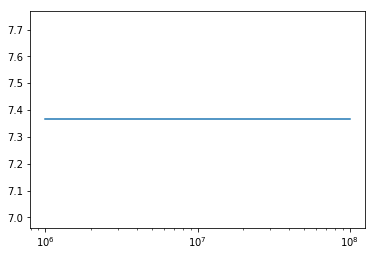

In [74]:
#LinearRegressionModel
##L1규칙화정도
###L1 규칙화이 필요한 레벨은 L2규칙화 보다 높으나, 전체적인 성능은 낮음

params=[10000.0, 1000000.0, 10000000.0, 100000000.0]
metrics=[evaluate(train_data, test_data, 10, 0.1, param, 'l1', False) for param in params]
print(params)
print(metrics)
plot(params, metrics)
fig=matplotlib.pyplot.gcf()
pyplot.xscale('log')
#모든 값이 nan으로 뜸 확인할 것
#L1 규칙화를 상사용할때는 가중치 벡터가 산발적으로 나타내게 가능함

/usr/local/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[False, True]
[6.4123177795736028, 6.0788158475436775]


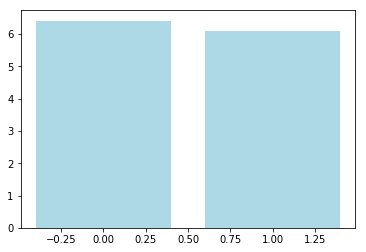

In [35]:
#LinearRegressionModel
##Intercept

params=[False, True]
metrics=[evaluate(train_data, test_data, 10, 0.00000005, 1.0, 'l2', param) for param in params]
print(params)
print(metrics)
bar(params, metrics, color='lightblue')
fig=matplotlib.pyplot.gcf()

In [36]:
#optimized_linear_model=evaluate(train_data, test_data, 1000, 0.001, 0.1, 'l2', True)
optimized_linear_model=LinearRegressionWithSGD.train(train_data, 1000, 0.01, regParam=0.1, regType='l2', intercept=True)

/usr/local/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


In [37]:
op_true_vs_pred=test_data.map(lambda t:(t.label, optimized_linear_model.predict(t.features)))

In [38]:
op_true_vs_pred.take(20)

[(78.0, 1.4888658561555358e+132),
 (261.0, 1.3098311466182766e+132),
 (286.0, 1.4444455506520342e+132),
 (459.0, 1.786515228594567e+132),
 (305.0, 1.5316426226954599e+132),
 (291.0, 1.3589520564305163e+132),
 (186.0, 1.3238233895255117e+132),
 (6518.0, 1.1708379573861641e+132),
 (5554.0, 1.0716921372920807e+132),
 (3309.0, 9.7564437994245469e+131),
 (4952.0, 1.9937312527704747e+132),
 (4981.0, 1.8154988843395266e+132),
 (1661.0, 1.9876519150927858e+132),
 (683.0, 1.9457976734190852e+132),
 (1184.0, 2.0349655186074605e+132),
 (1659.0, 2.1488653356077435e+132),
 (3115.0, 2.1191697322757939e+132),
 (756.0, 1.7718376534126737e+132),
 (177.0, 1.569586791040636e+132),
 (369.0, 1.9005381445138749e+132)]

In [39]:
final_preds_dt=final_model_dt.predict(test_data_dt.map(lambda d:d.features))
final_actual_dt=test_data_dt.map(lambda d:d.label)
final_true_vs_predicted_dt=actual.zip(preds)
final_true_vs_predicted_dt.take(30)

[(78.0, 372.0562640660165),
 (183.0, 1106.4384463462804),
 (143.0, 3227.1486586570113),
 (261.0, 3227.1486586570113),
 (286.0, 3227.1486586570113),
 (316.0, 3227.1486586570113),
 (393.0, 3227.1486586570113),
 (424.0, 3227.1486586570113),
 (452.0, 3227.1486586570113),
 (467.0, 3227.1486586570113),
 (459.0, 3227.1486586570113),
 (506.0, 3227.1486586570113),
 (490.0, 3227.1486586570113),
 (436.0, 3227.1486586570113),
 (305.0, 3227.1486586570113),
 (317.0, 3227.1486586570113),
 (299.0, 3227.1486586570113),
 (291.0, 3227.1486586570113),
 (186.0, 1395.9565503620804),
 (1555.0, 372.0562640660165),
 (1890.0, 1793.8978494623657),
 (1436.0, 3244.2418300653594),
 (1878.0, 3244.2418300653594),
 (2683.0, 3244.2418300653594),
 (2673.0, 3244.2418300653594),
 (2884.0, 3244.2418300653594),
 (3884.0, 3244.2418300653594),
 (4411.0, 3244.2418300653594),
 (4785.0, 3244.2418300653594),
 (4903.0, 3244.2418300653594)]

In [40]:
train_data_dt.take(10)

[LabeledPoint(5785.0, [41.0,17.0,0.84658215,0.492025331,0.587005961,0.608497998,0.555654967,0.579787327,0.564724703]),
 LabeledPoint(1399.0, [86.0,18.0,0.054508181,0.492025331,0.880564688,0.211315327,0.190057103,0.189785005,0.183191601]),
 LabeledPoint(452.0, [39.0,13.0,0.81843182,0.492025331,0.230222403,0.900759881,0.946628724,0.92233892,0.932746679]),
 LabeledPoint(1673.0, [79.0,16.0,0.181672846,0.492025331,0.502780157,0.290672314,0.304775779,0.329816831,0.323998456]),
 LabeledPoint(1728.0, [27.0,18.0,0.912977676,0.492025331,0.337683668,0.055403613,0.075675438,0.065923209,0.071262048]),
 LabeledPoint(490.0, [39.0,17.0,0.890294545,0.492025331,0.263799923,0.900759881,0.946628724,0.92233892,0.932746679]),
 LabeledPoint(672.0, [82.0,17.0,0.061005152,0.492025331,0.857999318,0.211315327,0.190057103,0.189785005,0.183191601]),
 LabeledPoint(299.0, [39.0,21.0,0.883095263,0.492025331,0.199179641,0.900759881,0.946628724,0.92233892,0.932746679]),
 LabeledPoint(1621.0, [73.0,9.0,0.677058229,0.492

In [41]:
test_data_dt.take(10)

[LabeledPoint(78.0, [39.0,5.0,0.488862391,0.492025331,0.377386277,0.900759881,0.946628724,0.92233892,0.932746679]),
 LabeledPoint(261.0, [39.0,8.0,0.481388916,0.492025331,0.377386277,0.900759881,0.946628724,0.92233892,0.932746679]),
 LabeledPoint(286.0, [39.0,9.0,0.503818452,0.492025331,0.101985849,0.900759881,0.946628724,0.92233892,0.932746679]),
 LabeledPoint(459.0, [39.0,15.0,0.875567369,0.492025331,0.122237011,0.900759881,0.946628724,0.92233892,0.932746679]),
 LabeledPoint(305.0, [39.0,19.0,0.879372657,0.492025331,0.199179641,0.900759881,0.946628724,0.92233892,0.932746679]),
 LabeledPoint(291.0, [39.0,22.0,0.859510748,0.492025331,0.1451563,0.900759881,0.946628724,0.92233892,0.932746679]),
 LabeledPoint(186.0, [39.0,23.0,0.863650964,0.492025331,0.122237011,0.900759881,0.946628724,0.92233892,0.932746679]),
 LabeledPoint(6518.0, [53.0,18.0,0.871678929,0.492025331,0.460381909,0.900759881,0.946628724,0.92233892,0.932746679]),
 LabeledPoint(5554.0, [53.0,21.0,0.871678929,0.492025331,0.33

In [42]:
final_true_vs_predicted_dt.take(1000)

[(78.0, 372.0562640660165),
 (183.0, 1106.4384463462804),
 (143.0, 3227.1486586570113),
 (261.0, 3227.1486586570113),
 (286.0, 3227.1486586570113),
 (316.0, 3227.1486586570113),
 (393.0, 3227.1486586570113),
 (424.0, 3227.1486586570113),
 (452.0, 3227.1486586570113),
 (467.0, 3227.1486586570113),
 (459.0, 3227.1486586570113),
 (506.0, 3227.1486586570113),
 (490.0, 3227.1486586570113),
 (436.0, 3227.1486586570113),
 (305.0, 3227.1486586570113),
 (317.0, 3227.1486586570113),
 (299.0, 3227.1486586570113),
 (291.0, 3227.1486586570113),
 (186.0, 1395.9565503620804),
 (1555.0, 372.0562640660165),
 (1890.0, 1793.8978494623657),
 (1436.0, 3244.2418300653594),
 (1878.0, 3244.2418300653594),
 (2683.0, 3244.2418300653594),
 (2673.0, 3244.2418300653594),
 (2884.0, 3244.2418300653594),
 (3884.0, 3244.2418300653594),
 (4411.0, 3244.2418300653594),
 (4785.0, 3244.2418300653594),
 (4903.0, 3244.2418300653594),
 (6092.0, 3244.2418300653594),
 (6634.0, 3244.2418300653594),
 (6518.0, 3244.2418300653594),